# Numerically Solving the Schrödinger Equation
by ``Anfernee Magbutay``

# Note: take the random error of the energy levels instead of the relative error

# For the finite square well bound states, try setting the N lower than 0 (??)

In this Python notebook, we will work on finding a purely numerical solution to the time independent Schrödinger Equation (SE). 
$$ -\frac{\hbar^2}{2m}\frac{d^2}{d x^2} \psi(x) + V(x)\psi(x) = E\psi(x)$$

## Method
The method we will use here is called the ["Finite Difference Method"](https://en.wikipedia.org/wiki/Finite_difference_method) (see the linked Wikipedia article). In this method we will turn the function $\psi(x)$ into a vector, which is a list in Python, and the operator of the differential equation into a *matrix*. We then end up with a matrix eigenequation, which we can diagonalize to get our answer.

### Discretization
The process of discretization is simply turning our continuous space $x$, into a discrete number of steps, $N$, and our function $\psi(x)$ into an array of size $N$. We thus have $N$ values $x_i$, which have a stepsize $h = \Delta x = x_{i+1} - x_i$. Our choice of the *size* of our space, $N$, turns out to be important. Too large a number will slow down our computation and require too much computer memory, too small a number and the answers we compute will not be sufficiently accurate. A common practice is to start with a small number $N$ and then increase it until the accuracy is acceptable. The actual value you obtain in the end will depend on the problem you are studying. 

### Forward and Backward first order differential
We first need to develop how we will take the derivative of our function. Going back to our introduction to calculus, we remember that the derivative was defined as:
$$
\frac{d}{dx} f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - f(x)}{\Delta x} \approx \frac{f(x+h) - f(x)}{h} + \mathrm{O}(h)
$$
When we take a *finite difference*, we simply not take the limit all the way down to 0, but stop at $\Delta x = h$. Note that for this equation we evaluate the point just *after* $x$, which we call the *forward difference*. If you actually let $\Delta x \rightarrow 0$, then this does not matter, but if you do a finite difference, you can also do:
$$
\frac{d}{dx} f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x) - f(x-\Delta x)}{\Delta x} \approx \frac{f(x) - f(x-h)}{h} + \mathrm{O}(h)
$$
which is known as the *backward difference*. 

You can also comput a *central difference*, but cannot use steps of $\frac{1}{2}\Delta x$, since that does not exist in our space. The central difference is then a combination of the previous two:
$$
\frac{d}{dx} f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - f(x-\Delta x)}{2\Delta x}\approx \frac{f(x+h) - f(x-h)}{2h} + \mathrm{O}(h^2)
$$
This last one is a little more accurate than the first two.

Note that for any of these approximations to a derivative, we have a problem at the edges of our space. (In Python, our space goes from $n=0$ to $n=N-1$.) Either on one end or the other, there is no $x-\Delta x$ or $x+\Delta x$. Here, we are just not going to worry about this detail.

#### Matrix representation

We now want to turn the equation into a matrix equation for us to evaluate. If you just want to take the derivative of a function stored in an array, then this is not needed, you can run a loop and evaluate the equation for each $x_i$, but if you want to solve a differential equation, we need the matrix.

We introduce the vectors $f(x) = [f_0,f_1,f_2,...,f_{N-1}]$ and for the derivative $f'(x) = [f'_0,f'_1,f'_2...,f'_{N-1}]$. The forward difference derivative can then be written as:
$$ f'_i = (f_{i+1} - f_i)/h $$
And the matrix equation for the forward difference derivative is just:
$$
\begin{pmatrix}f'_0 \\ f'_1 \\\vdots \\ f'_{N-1}\end{pmatrix} = \frac{1}{h}
\begin{pmatrix} -1 & 1 & 0 & & \\ 0 & -1 & 1 & & \\ & & \ddots & \ddots \\
& & & -1 & \end{pmatrix}\begin{pmatrix}f_0 \\ f_1 \\\vdots \\ f_{N-1}\end{pmatrix}
$$
We note that the last entry in the matrix will not be correct because there is no element for $N$. We can fix this up by taking the *backward* derivative at the last point.

We now check that this works. Using Python and Numpy we will take the derivative of $\sin(x)$ and plot the result.

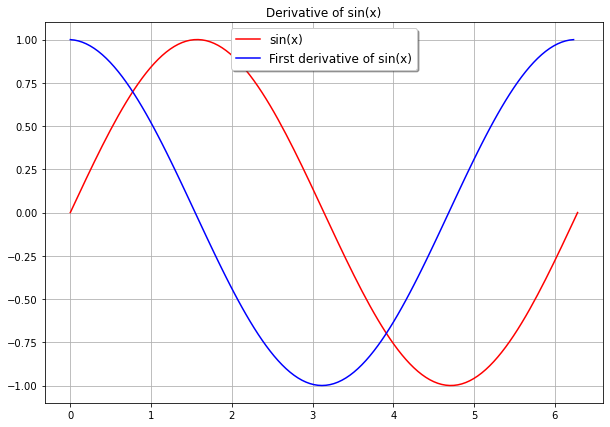

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Define the number of points in our space, n

n = 128
a = 2*np.pi

# Define the x space from 0 to a with n-1 divisions

x = np.linspace(0, 2*np.pi, n)

# Storing the step size

h = x[1] - x[0] # Equal to 2*np.pi/(n-1)

# Compute for the function y = sin(x)

y = np.sin(x)

# Compute the matrix using np.diag(np.ones(n), 0) which will create 
# a diagonal matrix of ones (nxn size)
# Multiply this by -1 to get -1 diagonal array as shown in the markdown above
# We then get a +1 off-diagonal array of ones, using np.diag(np.ones(n-1),1)
# Which needs to be n-1 for an nxn, since the off diagonal is one smaller
# Combining the two through addition and then normalize by 1/h

Md = 1./h*(np.diag( -1.*np.ones(n),0) + np.diag(np.ones(n-1),1))

# Compute the derivative of y into yp by matrix multiplication:

yp = Md.dot(y)
# Plot the results.
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Derivative of sin(x)')
ax.plot(x,y, 'r', label = 'sin(x)')
ax.plot(x[:-1],yp[:-1], 'b', label = 'First derivative of sin(x)') # Don't plot last value, which is invalid
legend = ax.legend(loc = 'upper center', shadow = True, fontsize ='large')
plt.grid(True)
plt.savefig('first_derivative.png')
plt.show()

## Second order Differential
We can now extend this method to the second order differential. If we take the backward differential of the result of a forward differential, we get:
$$
\frac{d^2}{dx^2}f(x) = \lim_{\Delta x \rightarrow 0} \frac{f'(x)-f'(x-\Delta x)}{\Delta x} =  \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - f(x) - (f(x) - f(x-\Delta x))}{\Delta x^2} \\
\frac{d^2}{dx^2}f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - 2f(x) + f(x-\Delta x))}{\Delta x^2} \approx \frac{f(x+h) - 2f(x) + f(x-h))}{h^2}
$$
So in the discrete space we can write this as:
$$ f''_i = (f_{i+1} - 2f_i + f_{i-1})/h^2 $$
And finally, as a matrix equation, the second derivative is then:
$$
\begin{pmatrix}f''_0 \\ f''_1 \\ f''_2 \\\vdots \\ f''_{N-1}\end{pmatrix} = \frac{1}{h^2}
\begin{pmatrix} -2 & 1 & 0 & 0 & \\ 1 & -2 & 1 & 0 & \\ 
0& 1 & -2 & 1 &  \\ &  & \ddots & \ddots & \ddots &\\
&  & & 1 & -2 \end{pmatrix}\begin{pmatrix}f_0 \\ f_1 \\ f_2 \\\vdots \\ f_{N-1}\end{pmatrix}
$$
Where now we note that at both ends of our array we will get an inaccurate answer unless we do some fixup. The fixup in this case is to use the same elements as the row below (at the start) or the row above (at the end), so we get $f''_0 = f''_1$ and $f''_{N-1} = f''_{N-2}$, which is not great but better than the alternative.

We can now try this matrix in Python and compute the second derivative of our $y(x)$ array.

[[-817.10468548  408.55234274    0.         ...    0.
     0.            0.        ]
 [ 408.55234274 -817.10468548  408.55234274 ...    0.
     0.            0.        ]
 [   0.          408.55234274 -817.10468548 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... -817.10468548
   408.55234274    0.        ]
 [   0.            0.            0.         ...  408.55234274
  -817.10468548  408.55234274]
 [   0.            0.            0.         ...    0.
   408.55234274 -817.10468548]]


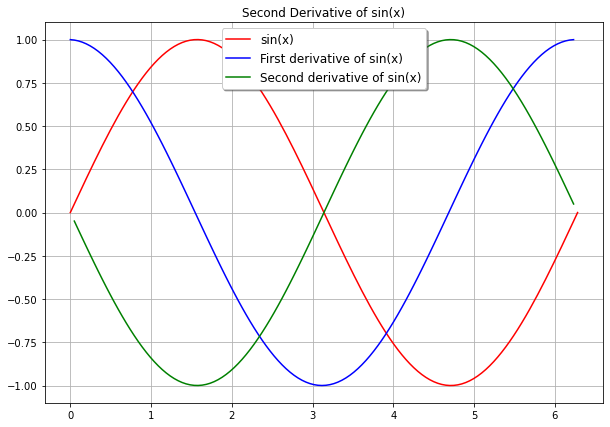

In [2]:
Mdd = 1./(h*h)*(np.diag(np.ones(n-1),-1) + np.diag( -2.*np.ones(n),0) + np.diag(np.ones(n-1),1))
print(Mdd)
ypp = Mdd.dot(y)

# Plot the results.
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Second Derivative of sin(x)')
ax.plot(x,y, 'r', label = 'sin(x)')
ax.plot(x[:-1],yp[:-1], 'b', label = 'First derivative of sin(x)') # Don't plot last value, which is invalid
ax.plot(x[1:-1], ypp[1:-1] , 'g', label = 'Second derivative of sin(x)') 
legend = ax.legend(loc = 'upper center', shadow = True, fontsize ='large')
plt.grid(True)
plt.savefig('second_derivative.png')
plt.show()

# Solving the Schrödinger Equation

We can now setup the Schrodinger Equation as a matrix equation:
$$
\hat H = \frac{\hbar^2}{2m}\frac{d^2}{d x^2} + V \\
\hat H \psi(x) = E \psi(x)
$$
We now know the matrix for taking the second order derivative. The matrix for the potential is simply the values of the potential on the diagonal of the matrix: $\mathbf{V}_{i=j} = V_i$. 

Writing out the matrix for $\mathbf{H}$ we get:
$$
\mathbf{H} = \frac{-\hbar^2}{2 m h^2} \begin{pmatrix} -2 & 1 & 0 & 0 & \\ 1 & -2 & 1 & 0 & \\ 
0& 1 & -2 & 1 &  \\ &  & \ddots & \ddots & \ddots &\\
&  & & 1 & -2 \end{pmatrix} + 
\begin{pmatrix} V_0 & 0 & 0 & & \\ 0 & V_1 & 0 & & \\ 0 & 0 & V_2 & & \\ & & &\ddots & \\ &&&&V_{N-1}\end{pmatrix}
$$ 

It is worth looking at the matrix of the Hamiltonian and notice the symmetry: $\mathbf{H}^T = \mathbf{H}$, so the transpose of the matrix is identical to the matrix. Since the matrix is *real* everywhere, the complex conjugate is also the same: $\mathbf{H}^*=\mathbf{H}$. Combining these two statements, we can say that the Hamiltonian is Hermetian: $\mathbf{H}^\dagger = \mathbf{H}$. 
### Infinite Square Well
The very simplest system to solve for is the infinite square well, for which $V=0$. We will readily recognize the results as alternating $\cos(x)$ and $\sin(x)$ functions, and the energy levels are:
$$
E_i = \frac{n^2\pi^2\hbar^2}{2ma^2}
$$
First, we need to discuss a subtlety. The Infinite Square Well from $-a/2$ to $a/2$ has $V=\infty$ *at* these points. We get into trouble trying to enter $\infty$ in our potential, so what we need to do is just limit the computational space from $-a/2+h$ to $a/2-h$, where $h$ is our step size. That way we force the wavefunction to zero at the end points. 
We compute this in the next box. I create $x_{full}$ as the full x-axis from $-a/2$ to $a/2$, but take $N+2$ steps. I then leave out the first and last point when calculating the wavefunctions. At the end, before plotting, I add a zero to the beginning and end of the wavefunctions, so that we get the expected result for plotting.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
start = time.time()

iterations = 5
E_1 = []
E_2 = []
E_3 = []
E_4 = []
E_5 = []
for _ in range(iterations):
    # setting up our parameters
    hbar=1
    m=1
    N = 4096
    a = 1.0
    x = np.linspace(-a/2.,a/2.,N)
    #x = np.sort((2. * np.random.rand(N) - 1.) / 2.)
    # We want to store step size, this is the reliable way:
    h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)
    V = 0.*x
    #implementing the FDM
    Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
    H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
    E,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
    # obtaining the values for the first 5 energy levels to calculate the error 
    E_1.append(E[0]) # first energy level
    E_2.append(E[1]) # second
    E_3.append(E[2]) # third
    E_4.append(E[3]) # fourth
    E_5.append(E[4]) # fifth
    psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
end = time.time()-start
print(f'Total time: {end} seconds')

Total time: 36.5672926902771 seconds


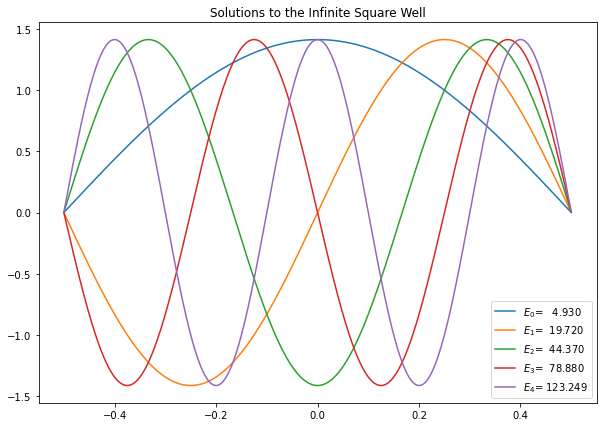

In [4]:
plt.figure(figsize=(10,7))
for i in range(5):
    if psi[i][N-10] < 0:   # Flip the wavefunctions if it is negative at large x, so plots are more consistent.
        plt.plot(x,-psi[i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,E[i]))
    else:
        plt.plot(x,psi[i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,E[i]))
    plt.title("Solutions to the Infinite Square Well")
plt.legend()
plt.savefig("Infinite_Square_Well_WaveFunctions.png")
plt.show()

We now also want to check that the energy levels do indeed correspond to the known levels:
$$
E_n = \frac{n^2 \pi^2 \hbar^2}{2 m a^2}
$$

## First we compute for the theoretical values of the Energy levels in this problem

In [5]:
theoretical_val = []
for i in range(10):
    n = i+1
    theoretical_val.append(n*n*np.pi**2*hbar*hbar/(2*m*a*a))

## We then compare it with our experimental results
\
On the first column we have our experimental results, and on the second column we have the theoretical results

In [6]:
for i in range(10):
    n = i+1
    print("E[{}] = {:9.4f}, E_{} ={:9.4f}".format(n,E[i],n, theoretical_val[i]))

E[1] =    4.9300, E_1 =   4.9348
E[2] =   19.7199, E_2 =  19.7392
E[3] =   44.3698, E_3 =  44.4132
E[4] =   78.8797, E_4 =  78.9568
E[5] =  123.2495, E_5 = 123.3701
E[6] =  177.4792, E_6 = 177.6529
E[7] =  241.5687, E_7 = 241.8053
E[8] =  315.5181, E_8 = 315.8273
E[9] =  399.3272, E_9 = 399.7190
E[10] =  492.9961, E_10 = 493.4802


In [7]:
# Calculating the error between experimental and theoretical value
error = [abs(i-j)/i*100 for i,j in zip(theoretical_val, E)]

In [8]:
for j in range(10):
    print("E[{}] = {:9.4f} +- {:9.4f}".format(j+1, E[j], error[j]))

E[1] =    4.9300 +-    0.0976
E[2] =   19.7199 +-    0.0976
E[3] =   44.3698 +-    0.0977
E[4] =   78.8797 +-    0.0977
E[5] =  123.2495 +-    0.0977
E[6] =  177.4792 +-    0.0978
E[7] =  241.5687 +-    0.0978
E[8] =  315.5181 +-    0.0979
E[9] =  399.3272 +-    0.0980
E[10] =  492.9961 +-    0.0981


## A final test to show the accuracy of the calculation in the orthonormality of the states

In [9]:
for j in range(5):
    for i in range(5):
        print("{:16.9e}".format(np.sum(psi[j]*psi[i])))

 1.000000000e+00
-1.665334537e-16
 8.326672685e-16
 3.330669074e-16
-6.938893904e-16
-1.665334537e-16
 1.000000000e+00
 3.330669074e-16
 4.662936703e-15
-1.804112415e-16
 8.326672685e-16
 3.330669074e-16
 1.000000000e+00
 0.000000000e+00
-5.551115123e-17
 3.330669074e-16
 4.662936703e-15
 0.000000000e+00
 1.000000000e+00
 4.440892099e-16
-6.938893904e-16
-1.804112415e-16
-5.551115123e-17
 4.440892099e-16
 1.000000000e+00


## Some Application: Calculating the Bound States of a Finite Well

We use the  calculate the bound states for a finite square well. There are only a few changes to the square well solution. The potential is different, in that it has a small area which is not zero but some negative value, here $-V_0$. For our calculation to be approximately correct, we need to make sure that our entire calculation space, from $-a/2$ to $a/2$ is much larger than the well, wich is from $-b/2.$ to $b/2$. The factor 100 I choose here is probably more than needed. We also need a fairly large $N$, the number of steps in our space, so that the resulting wave function is smooth in the area of the well.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
start = time.time()
hbar=1
m=1
N = 4097
a = 200.0
b = 2.
x = np.linspace(-a/2.,a/2.,N)
# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)
V0 = -6.
V=np.zeros(N)
for i in range(N):
    if x[i]> -b/2. and x[i]< b/2.:
        V[i]= V0

Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
bound_E,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
end = time.time()-start
print(f'Total time: {end} seconds')

Total time: 6.477925539016724 seconds


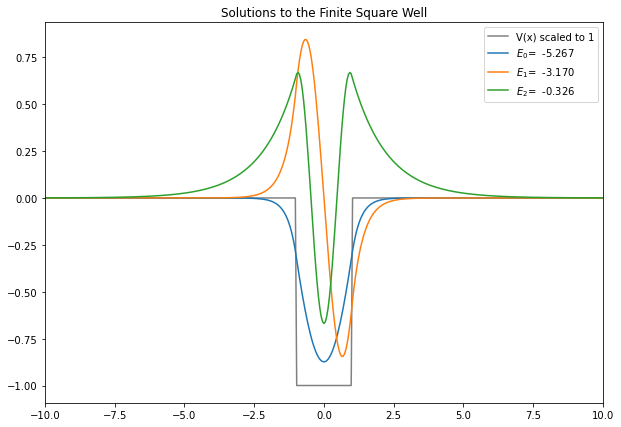

In [11]:
plt.figure(figsize=(10,7))
plt.xlim((-5*b,5*b))
plt.plot(x,V/(-V0),color="Gray",label="V(x) scaled to 1")
for i in range(5):
    if bound_E[i]<0:                 # Only plot the bound states. The scattering states are not reliably computed.
        if psi[i][N-10] < 0:   # Flip the wavefunctions if it is negative at large x, so plots are more consistent.
            plt.plot(x,-psi[i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,bound_E[i]))
        else:
            plt.plot(x,psi[i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,bound_E[i]))
plt.title("Solutions to the Finite Square Well")
plt.legend()
plt.savefig("Finite_Square_Well_WaveFunctions.png")
plt.show()
